In [1]:
# generate data
# list of points
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(21)
from matplotlib.backends.backend_pdf import PdfPages

means = [[2, 2], [4, 1]]
cov = [[.3, .2], [.2, .3]]
N = 10
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X1[-1, :] = [2.7, 2]
X = np.concatenate((X0.T, X1.T), axis = 1)
y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1)

Cách 1. Tự xây dựng các bước giải bài toán ràng buộc:

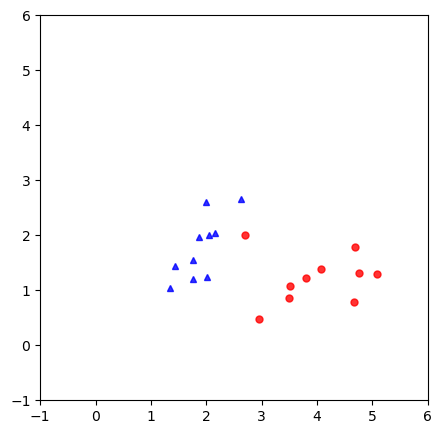

In [2]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))

ani = plt.cla()
#plot points
ani = plt.plot(X0.T[0, :], X0.T[1, :], 'b^', markersize = 5, alpha = .8)
ani = plt.plot(X1.T[0, :], X1.T[1, :], 'ro', markersize = 5, alpha = .8)
ani = plt.axis([-1 , 6, -1, 6])
plt.show()

In [3]:
from cvxopt import matrix, solvers
C = 100
# build K
V = np.concatenate((X0.T, -X1.T), axis = 1)
K = matrix(V.T.dot(V))

p = matrix(-np.ones((2*N, 1)))
# build A, b, G, h
G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))

h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))
A = matrix(y.reshape((-1, 2*N)))
b = matrix(np.zeros((1, 1)))
solvers.options['show_progress'] = False
sol = solvers.qp(K, p, G, h, A, b)

l = np.array(sol['x'])
print('lambda = \n', l.T)

lambda = 
 [[1.26997770e-08 7.29907090e-09 6.75263620e+00 1.20067067e-08
  8.83482181e-09 1.00135373e-08 9.49241066e-09 1.10095260e-08
  1.09448265e-08 1.15277180e+01 3.06483278e-09 2.92217775e-09
  3.52341246e-09 5.49363383e-09 4.48478627e-09 7.55953464e-09
  2.73325320e-09 5.71296652e-09 5.02756847e-09 1.82803543e+01]]


In [4]:
S = np.where(l > 1e-5)[0] # support set
S2 = np.where(l < .999*C)[0]

M = [val for val in S if val in S2] # intersection of two lists

# XT = X.T # we need each column to be one data point in this alg
VS = V[:, S]
lS = l[S]
yM = y[:, M]
XM = X[:, M]

w_dual = VS.dot(lS).reshape(-1, 1)
b_dual = np.mean(yM.T - w_dual.T.dot(XM))
print(w_dual.T, b_dual)

[[-5.54276837  2.41628387]] 9.132906850859719


Cách 2. Xây dựng phương pháp giải bài toán tối ưu không ràng buộc:

In [5]:
X0_bar = np.vstack((X0.T, np.ones((1, N)))) # extended data
X1_bar = np.vstack((X1.T, np.ones((1, N)))) # extended data

Z = np.hstack((X0_bar, - X1_bar)) # as in (22)
lam = 1./C

def cost(w):
    u = w.T.dot(Z) # as in (23)
    return (np.sum(np.maximum(0, 1 - u)) + .5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1] # no bias

def grad(w):
    u = w.T.dot(Z) # as in (23)
    H = np.where(u < 1)[1]
    ZS = Z[:, H]
    g = (-np.sum(ZS, axis = 1, keepdims = True) + lam*w)
    g[-1] -= lam*w[-1] # no weight decay on bias
    return g

eps = 1e-6
def num_grad(w):
    g = np.zeros_like(w)
    for i in range(len(w)):
        wp = w.copy()
        wm = w.copy()
        wp[i] += eps
        wm[i] -= eps
        g[i] = (cost(wp) - cost(wm))/(2*eps)
    return g

w0 = np.random.randn(X0_bar.shape[0], 1)
g1 = grad(w0)
g2 = num_grad(w0)
diff = np.linalg.norm(g1 - g2)
print('Gradient different: %f' %diff)

Gradient different: 0.000000


In [6]:
def grad_descent(w0, eta):
    w = w0
    it = 0
    while it < 100000:
        it = it + 1
        g = grad(w)
        w -= eta*g
        if (it % 10000) == 1:
            print('iter %d' %it + ' cost: %f' %cost(w))
        if np.linalg.norm(g) < 1e-5:
            break
    return w

w0 = np.random.randn(X0_bar.shape[0], 1)
w = grad_descent(w0, 0.001)
w_hinge = w[:-1].reshape(-1, 1)
b_hinge = w[-1]
print(w_hinge.T, b_hinge)

iter 1 cost: 87.184655
iter 10001 cost: 1.430915
iter 20001 cost: 1.092201
iter 30001 cost: 0.779892
iter 40001 cost: 0.491327
iter 50001 cost: 0.218693
iter 60001 cost: 0.183223
iter 70001 cost: 0.183222
iter 80001 cost: 0.183221
iter 90001 cost: 0.183220
[[-5.54923267  2.41881653]] [9.14508377]


Cách 3. Sử dụng thư viện:

In [7]:
from sklearn.svm import SVC
# Copy and put code for generate data here
y1 = y.reshape((2*N,))
X1 = X.T # each sample is one row
clf = SVC(kernel = 'linear', C = 100) # use the same C
# if C is small, method will be “SoftMagin SVM”,
# if C is large enough, method is near to hard margin
clf.fit(X1, y1)

w = clf.coef_
w0 = clf.intercept_
print('w = ', w)
print('b = ', w0)

w =  [[-5.54202362  2.4156074 ]]
b =  [9.13241559]


Kết quả từ 3 phương pháp có bộ hệ số gần giống nhau

Bài tập thực hành 1: Xem lại các bài ví dụ phần trước, sử dụng bộ trọng số W đã tính được và dự đoán các phân lớp y ứng với dữ liệu
X trên chính tập dữ liệu ngẫu nhiên vừa tạo. Đưa ra độ chính xác Accuracy và ma trận nhầm lẫn Confusion Matrix.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(1121)
from matplotlib.backends.backend_pdf import PdfPages

means = [[2, 2], [4, 1]]
cov = [[.3, .2], [.2, .3]]
N = 200
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X1[-1, :] = [2.7, 2]
X = np.concatenate((X0.T, X1.T), axis = 1)
y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1)

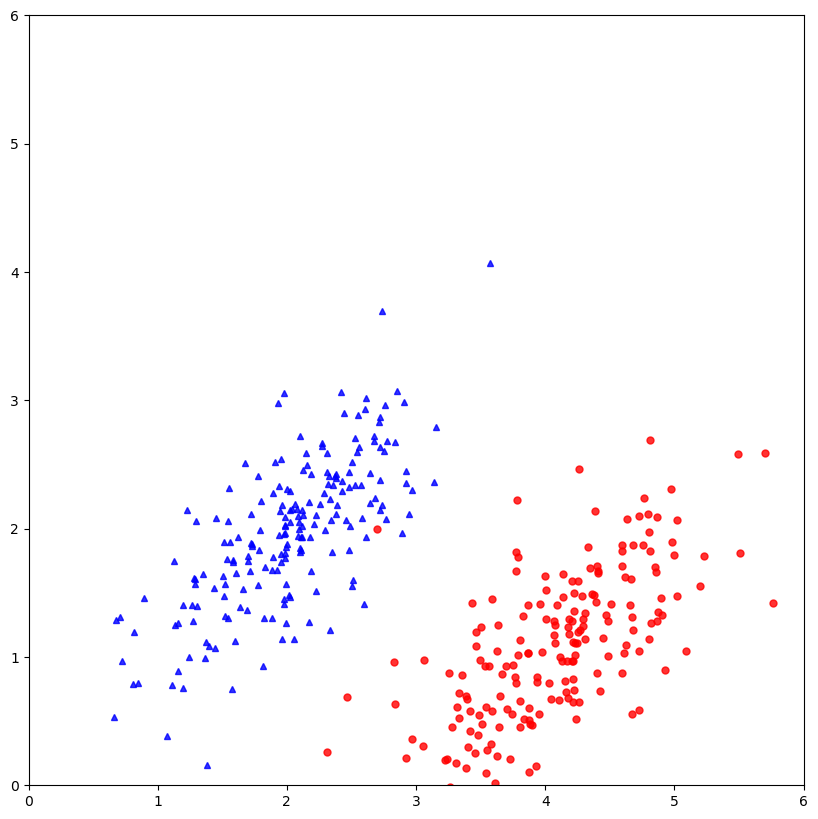

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
ani = plt.cla()
#plot points
ani = plt.plot(X0.T[0, :], X0.T[1, :], 'b^', markersize = 5, alpha = .8)
ani = plt.plot(X1.T[0, :], X1.T[1, :], 'ro', markersize = 5, alpha = .8)
ani = plt.axis([0 , 6, 0, 6])
plt.show()

In [10]:
y1 = y.reshape((2*N,))
X1 = X.T # each sample is one row

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [11]:
from sklearn.svm import SVC

clf = SVC(kernel = 'linear', C = 100) # use the same C
# if C is small, method will be “SoftMagin SVM”,
# if C is large enough, method is near to hard margin
clf.fit(X_train, y_train)

w = clf.coef_
w0 = clf.intercept_
print('w = ', w)
print('b = ', w0)

w =  [[-3.88521019  2.87059132]]
b =  [6.58987168]


In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

cfs_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix: ")
print(cfs_matrix)

Accuracy:  1.0
Confusion matrix: 
[[36  0]
 [ 0 44]]
